In [1]:
# Imports
import os
import torch
import torch.optim as optim
import torch.nn as nn
import shutil
import numpy as np
import torchvision
import albumentations as A
import sys
os.chdir('D:\\coding\cs5242-project')  # 替换为 `cs5242-project` 的绝对路径
sys.path.append(os.path.abspath('./data_augmentation'))

from data_augmentation import augmentation
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification
from tqdm import tqdm
from sklearn.model_selection import train_test_split

d:\coding\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\coding\venv\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
print(device)
model.to(device)

True
cuda


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [8]:
torch.backends.cudnn.benchmark=True

In [3]:
with torch.cuda.device(device):
    torch.cuda.empty_cache()
    print(f"Memory allocated after clearing cache: {torch.cuda.memory_allocated(device)}")


torch.cuda.max_memory_allocated()

Memory allocated after clearing cache: 346270720


346270720

## Data Preperation

In [ ]:
# Apply augmentation here
# remember to change input_folder and output_folder!!!
os.chdir('D://coding/')  
sys.path.append(os.path.abspath('./extracted'))

char_list = ['dori', 'lisa', 'amber', 'childe', 'venti', 'zhongli', 'eula', 'ganyu', 'hutao', 'yoimiya', 'raiden', 'nahida']
augmentation.process_folder(char_list, num_aug=3)

In [4]:
# Target is on all the root directory for all the _extracted folders
os.chdir('D://coding/')  
dataset_dir = './augmented' # Whatever folder the augmented dataset is in
train_dir = './processed_splits/train'  # Destination for training set
test_dir = './processed_splits/test'    # Destination for test set
val_dir = './processed_splits/val'    # Destination for validation set

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [2]:
def train_test_val_split(dataset_dir, test_size, val_size):
    for character_folder in os.listdir(dataset_dir):
        character_path = os.path.join(dataset_dir, character_folder)

        if os.path.isdir(character_path):
            # Get all image filenames for the current character
            images = os.listdir(character_path)

            # Split into train+val and test sets
            train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=5242)

            # Split train_val into train and val sets
            train_images, val_images = train_test_split(train_val_images, test_size=val_size, random_state=5242)

            # Create train, val, and test subfolders for the character
            train_character_dir = os.path.join(train_dir, character_folder)
            val_character_dir = os.path.join(val_dir, character_folder)
            test_character_dir = os.path.join(test_dir, character_folder)
            os.makedirs(train_character_dir, exist_ok=True)
            os.makedirs(val_character_dir, exist_ok=True)
            os.makedirs(test_character_dir, exist_ok=True)

            # Move training images
            for image in train_images:
                src_image_path = os.path.join(character_path, image)
                dst_image_path = os.path.join(train_character_dir, image)
                shutil.copy(src_image_path, dst_image_path)

            # Move validation images
            for image in val_images:
                src_image_path = os.path.join(character_path, image)
                dst_image_path = os.path.join(val_character_dir, image)
                shutil.copy(src_image_path, dst_image_path)

            # Move testing images
            for image in test_images:
                src_image_path = os.path.join(character_path, image)
                dst_image_path = os.path.join(test_character_dir, image)
                shutil.copy(src_image_path, dst_image_path)

            print(f'Successfully split {character_folder} into train/test/val sets.')

In [11]:
# Define split ratios
test_size = 0.15
val_size = 0.15

In [27]:
train_test_val_split(dataset_dir, test_size, val_size)

Successfully split amber_augmented into train/test/val sets.
Successfully split childe_augmented into train/test/val sets.
Successfully split dori_augmented into train/test/val sets.
Successfully split eula_augmented into train/test/val sets.
Successfully split ganyu_augmented into train/test/val sets.
Successfully split hutao_augmented into train/test/val sets.
Successfully split lisa_augmented into train/test/val sets.
Successfully split nahida_augmented into train/test/val sets.
Successfully split raiden_augmented into train/test/val sets.
Successfully split venti_augmented into train/test/val sets.
Successfully split yoimiya_augmented into train/test/val sets.
Successfully split zhongli_augmented into train/test/val sets.


In [5]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=transform)

# Pass these datasets to DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False,num_workers=4)

# Training

In [6]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
#optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False, maximize=False, foreach=None, capturable=False, differentiable=False, fused=None)

# Learning Rate Scheduler
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [8]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=30, patience=5):
    best_val_accuracy = 0.0
    trigger_times = 0

    train_losses=[]
    val_losses=[]
    train_accuracies=[]
    val_accuracies=[]
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).logits
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation Phase
        model.eval()
        val_running_corrects = 0
        val_running_loss = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation', leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs).logits
                _, preds = torch.max(outputs, 1)
                loss=criterion(outputs,labels)

                val_running_loss+=loss.item()*inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_accuracy = val_running_corrects.double() / len(val_loader.dataset)
        val_loss=val_running_loss/len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy.item)
        
        print(f'Validation Acc: {val_accuracy:.4f}')

        # Check for improvement
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            print('Best model saved.')
            trigger_times = 0
        else:
            trigger_times += 1
            print(f'No improvement for {trigger_times} epoch(s).')

            if trigger_times >= patience:
                print('Early stopping triggered.')
                break

    

        # Step the scheduler
        scheduler.step()

    print(f'Training complete. Best Validation Accuracy: {best_val_accuracy:.4f}')

    return train_losses,val_losses

## Plot

In [9]:
import matplotlib.pyplot as plt
def compareOptim(train_loader,val_loader,criterion,optimizer_classes,device,num_epochs=30,patience=5):
    optimizer_results={}

    for opt_name,opt_class in optimizer_classes.items():
        print(f'\nTraining with:{opt_name}')

        model=ViTForImageClassification.from_pretrained('google/vit-base-patch16-224').to(device)
        optimizer=opt_class(model.parameters())
        scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)

        train_losses,val_losses = train(model,train_loader,val_loader,criterion,optimizer,scheduler,device,num_epochs,patience)
        optimizer_results[opt_name]={'train':train_losses,'val':val_losses}
    plt.figure(figsize=(12,6))

    for opt_name,losses in optimizer_results.items():
        plt.plot(losses['train'],label=f'{opt_name} - Train')
        plt.plot(losses['val'],linestyle='--',label=f'{opt_name} - Val')


    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss for Different Optimizers')
    plt.legend()
    plt.show()

optimizer_classes = {
     'AdamW': lambda params: optim.AdamW(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False),
    'SGD': lambda params: optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.01),
    'SGDM': lambda params: optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True, weight_decay=0.01),
    'Adam': lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
}


Training with:AdamW
Epoch 1/30
----------


Training Loss: 1.8605 Acc: 0.4104


Validation Acc: 0.7313
Best model saved.
Epoch 2/30
----------


Training Loss: 0.8152 Acc: 0.7338


Validation Acc: 0.7651
Best model saved.
Epoch 3/30
----------


Training Loss: 0.4925 Acc: 0.8484


Validation Acc: 0.8091
Best model saved.
Epoch 4/30
----------


Training Loss: 0.3850 Acc: 0.8762


Validation Acc: 0.8634
Best model saved.
Epoch 5/30
----------


Training Loss: 0.3166 Acc: 0.9015


Validation Acc: 0.8443
No improvement for 1 epoch(s).
Epoch 6/30
----------


Training Loss: 0.2471 Acc: 0.9243


Validation Acc: 0.8311
No improvement for 2 epoch(s).
Epoch 7/30
----------


Training Loss: 0.2454 Acc: 0.9201


Validation Acc: 0.8546
No improvement for 3 epoch(s).
Epoch 8/30
----------


Training Loss: 0.2491 Acc: 0.9212


Validation Acc: 0.8341
No improvement for 4 epoch(s).
Epoch 9/30
----------


Training Loss: 0.1586 Acc: 0.9493


Validation Acc: 0.8649
Best model saved.
Epoch 10/30
----------


Training Loss: 0.1828 Acc: 0.9401


Validation Acc: 0.8649
No improvement for 1 epoch(s).
Epoch 11/30
----------


Training Loss: 0.0397 Acc: 0.9895


Validation Acc: 0.8972
Best model saved.
Epoch 12/30
----------


Training Loss: 0.0081 Acc: 0.9987


Validation Acc: 0.9016
Best model saved.
Epoch 13/30
----------


Training Loss: 0.0037 Acc: 1.0000


Validation Acc: 0.9001
No improvement for 1 epoch(s).
Epoch 14/30
----------


Training Loss: 0.0025 Acc: 1.0000


Validation Acc: 0.8987
No improvement for 2 epoch(s).
Epoch 15/30
----------


Training Loss: 0.0018 Acc: 1.0000


Validation Acc: 0.8987
No improvement for 3 epoch(s).
Epoch 16/30
----------


Training Loss: 0.0013 Acc: 1.0000


Validation Acc: 0.9016
No improvement for 4 epoch(s).
Epoch 17/30
----------


Training Loss: 0.0010 Acc: 1.0000


Validation Acc: 0.9001
No improvement for 5 epoch(s).
Early stopping triggered.
Training complete. Best Validation Accuracy: 0.9016

Training with:SGD
Epoch 1/30
----------


Training Loss: 2.2485 Acc: 0.4900


Validation Acc: 0.7944
Best model saved.
Epoch 2/30
----------


Training Loss: 0.4000 Acc: 0.8949


Validation Acc: 0.9310
Best model saved.
Epoch 3/30
----------


Training Loss: 0.1821 Acc: 0.9598


Validation Acc: 0.9369
Best model saved.
Epoch 4/30
----------


Training Loss: 0.1087 Acc: 0.9795


Validation Acc: 0.9501
Best model saved.
Epoch 5/30
----------


Training Loss: 0.0673 Acc: 0.9924


Validation Acc: 0.9633
Best model saved.
Epoch 6/30
----------


Training Loss: 0.0477 Acc: 0.9963


Validation Acc: 0.9633
No improvement for 1 epoch(s).
Epoch 7/30
----------


Training Loss: 0.0393 Acc: 0.9968


Validation Acc: 0.9677
Best model saved.
Epoch 8/30
----------


Training Loss: 0.0305 Acc: 0.9995


Validation Acc: 0.9618
No improvement for 1 epoch(s).
Epoch 9/30
----------


Training Loss: 0.0271 Acc: 0.9995


Validation Acc: 0.9662
No improvement for 2 epoch(s).
Epoch 10/30
----------


Training Loss: 0.0257 Acc: 0.9995


Validation Acc: 0.9677
No improvement for 3 epoch(s).
Epoch 11/30
----------


Training Loss: 0.0214 Acc: 0.9995


Validation Acc: 0.9677
No improvement for 4 epoch(s).
Epoch 12/30
----------


Training Loss: 0.0209 Acc: 0.9997


Validation Acc: 0.9677
No improvement for 5 epoch(s).
Early stopping triggered.
Training complete. Best Validation Accuracy: 0.9677

Training with:SGDM
Epoch 1/30
----------


Training Loss: 2.1331 Acc: 0.5273


Validation Acc: 0.8414
Best model saved.
Epoch 2/30
----------


Training Loss: 0.3753 Acc: 0.9009


Validation Acc: 0.9251
Best model saved.
Epoch 3/30
----------


Training Loss: 0.1737 Acc: 0.9614


Validation Acc: 0.9471
Best model saved.
Epoch 4/30
----------


Training Loss: 0.0988 Acc: 0.9816


Validation Acc: 0.9559
Best model saved.
Epoch 5/30
----------


Training Loss: 0.0597 Acc: 0.9929


Validation Acc: 0.9604
Best model saved.
Epoch 6/30
----------


Training Loss: 0.0415 Acc: 0.9974


Validation Acc: 0.9574
No improvement for 1 epoch(s).
Epoch 7/30
----------


Training Loss: 0.0323 Acc: 0.9987


Validation Acc: 0.9618
Best model saved.
Epoch 8/30
----------


Training Loss: 0.0272 Acc: 0.9997


Validation Acc: 0.9662
Best model saved.
Epoch 9/30
----------


Training Loss: 0.0258 Acc: 0.9995


Validation Acc: 0.9633
No improvement for 1 epoch(s).
Epoch 10/30
----------


Training Loss: 0.0244 Acc: 0.9992


Validation Acc: 0.9633
No improvement for 2 epoch(s).
Epoch 11/30
----------


Training Loss: 0.0201 Acc: 0.9997


Validation Acc: 0.9648
No improvement for 3 epoch(s).
Epoch 12/30
----------


Training Loss: 0.0192 Acc: 0.9997


Validation Acc: 0.9633
No improvement for 4 epoch(s).
Epoch 13/30
----------


Training Loss: 0.0191 Acc: 0.9997


Validation Acc: 0.9589
No improvement for 5 epoch(s).
Early stopping triggered.
Training complete. Best Validation Accuracy: 0.9662

Training with:Adam
Epoch 1/30
----------


Training Loss: 2.1434 Acc: 0.3085


Validation Acc: 0.4200
Best model saved.
Epoch 2/30
----------


Training Loss: 1.6946 Acc: 0.4023


Validation Acc: 0.4288
Best model saved.
Epoch 3/30
----------


Training Loss: 1.4025 Acc: 0.5021


Validation Acc: 0.5756
Best model saved.
Epoch 4/30
----------


Training Loss: 1.3004 Acc: 0.5468


Validation Acc: 0.6388
Best model saved.
Epoch 5/30
----------


Training Loss: 1.1901 Acc: 0.5996


Validation Acc: 0.6373
No improvement for 1 epoch(s).
Epoch 6/30
----------


Training Loss: 1.1222 Acc: 0.6182


Validation Acc: 0.6564
Best model saved.
Epoch 7/30
----------


Training Loss: 1.0713 Acc: 0.6503


Validation Acc: 0.6769
Best model saved.
Epoch 8/30
----------


Training Loss: 1.0549 Acc: 0.6503


Validation Acc: 0.6960
Best model saved.
Epoch 9/30
----------


Training Loss: 1.0294 Acc: 0.6618


Validation Acc: 0.6637
No improvement for 1 epoch(s).
Epoch 10/30
----------


Training Loss: 0.9676 Acc: 0.6871


Validation Acc: 0.7122
Best model saved.
Epoch 11/30
----------


Training Loss: 0.8198 Acc: 0.7380


Validation Acc: 0.7489
Best model saved.
Epoch 12/30
----------


Training Loss: 0.7819 Acc: 0.7520


Validation Acc: 0.7460
No improvement for 1 epoch(s).
Epoch 13/30
----------


Training Loss: 0.7714 Acc: 0.7538


Validation Acc: 0.7474
No improvement for 2 epoch(s).
Epoch 14/30
----------


Training Loss: 0.7568 Acc: 0.7575


Validation Acc: 0.7636
Best model saved.
Epoch 15/30
----------


Training Loss: 0.7446 Acc: 0.7648


Validation Acc: 0.7739
Best model saved.
Epoch 16/30
----------


Training Loss: 0.7297 Acc: 0.7727


Validation Acc: 0.7665
No improvement for 1 epoch(s).
Epoch 17/30
----------


Training Loss: 0.7255 Acc: 0.7730


Validation Acc: 0.7768
Best model saved.
Epoch 18/30
----------


Training Loss: 0.7127 Acc: 0.7782


Validation Acc: 0.7768
No improvement for 1 epoch(s).
Epoch 19/30
----------


Training Loss: 0.7045 Acc: 0.7796


Validation Acc: 0.7724
No improvement for 2 epoch(s).
Epoch 20/30
----------


Training Loss: 0.6947 Acc: 0.7769


Validation Acc: 0.7841
Best model saved.
Epoch 21/30
----------


Training Loss: 0.6620 Acc: 0.7916


Validation Acc: 0.7885
Best model saved.
Epoch 22/30
----------


Training Loss: 0.6536 Acc: 0.7937


Validation Acc: 0.7930
Best model saved.
Epoch 23/30
----------


Training Loss: 0.6511 Acc: 0.7974


Validation Acc: 0.7885
No improvement for 1 epoch(s).
Epoch 24/30
----------


Training Loss: 0.6491 Acc: 0.7974


Validation Acc: 0.7900
No improvement for 2 epoch(s).
Epoch 25/30
----------


Training Loss: 0.6465 Acc: 0.8014


Validation Acc: 0.7885
No improvement for 3 epoch(s).
Epoch 26/30
----------


Training Loss: 0.6454 Acc: 0.8022


Validation Acc: 0.7930
No improvement for 4 epoch(s).
Epoch 27/30
----------


Training Loss: 0.6445 Acc: 0.8024


Validation Acc: 0.7871
No improvement for 5 epoch(s).
Early stopping triggered.
Training complete. Best Validation Accuracy: 0.7930


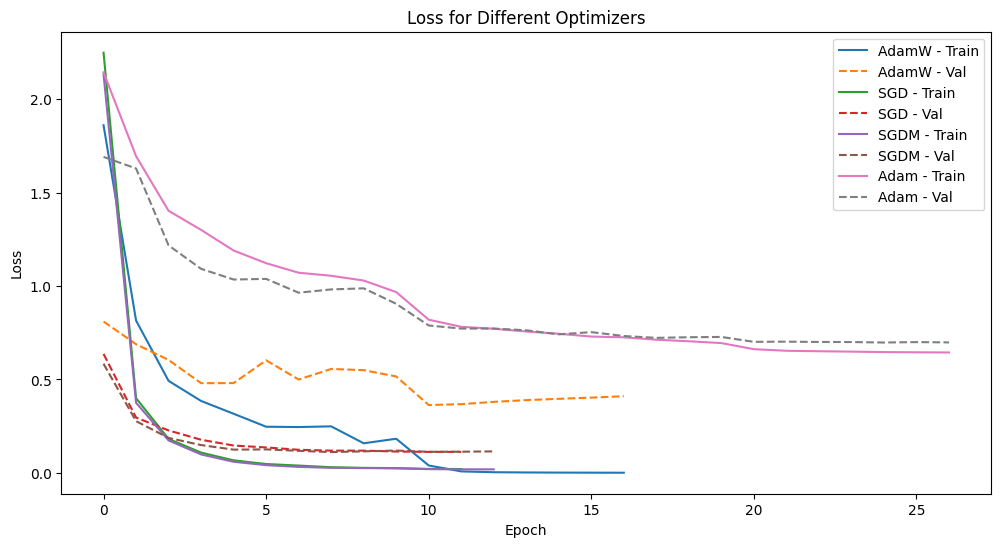

In [10]:
compareOptim(train_loader, val_loader, criterion, optimizer_classes, device)

## Evaluation

In [34]:
train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=30, patience=5)

Epoch 1/30
----------


Training Loss: 2.0531 Acc: 0.3389


Validation Acc: 0.6329
Best model saved.
Epoch 2/30
----------


Training Loss: 0.8674 Acc: 0.7131


Validation Acc: 0.8297
Best model saved.
Epoch 3/30
----------


Training Loss: 0.5915 Acc: 0.8061


Validation Acc: 0.7856
No improvement for 1 epoch(s).
Epoch 4/30
----------


Training Loss: 0.4579 Acc: 0.8523


Validation Acc: 0.8047
No improvement for 2 epoch(s).
Epoch 5/30
----------


Training Loss: 0.3737 Acc: 0.8770


Validation Acc: 0.8311
Best model saved.
Epoch 6/30
----------


Training Loss: 0.3327 Acc: 0.8962


Validation Acc: 0.8106
No improvement for 1 epoch(s).
Epoch 7/30
----------


Training Loss: 0.2356 Acc: 0.9212


Validation Acc: 0.8311
No improvement for 2 epoch(s).
Epoch 8/30
----------


Training Loss: 0.2008 Acc: 0.9335


Validation Acc: 0.8253
No improvement for 3 epoch(s).
Epoch 9/30
----------


Training Loss: 0.2031 Acc: 0.9325


Validation Acc: 0.8546
Best model saved.
Epoch 10/30
----------


Training Loss: 0.1795 Acc: 0.9409


Validation Acc: 0.8517
No improvement for 1 epoch(s).
Epoch 11/30
----------


Training Loss: 0.0443 Acc: 0.9855


Validation Acc: 0.8928
Best model saved.
Epoch 12/30
----------


Training Loss: 0.0096 Acc: 0.9984


Validation Acc: 0.9031
Best model saved.
Epoch 13/30
----------


Training Loss: 0.0060 Acc: 0.9995


Validation Acc: 0.9046
Best model saved.
Epoch 14/30
----------


Training Loss: 0.0044 Acc: 0.9995


Validation Acc: 0.9031
No improvement for 1 epoch(s).
Epoch 15/30
----------


Training Loss: 0.0035 Acc: 0.9995


Validation Acc: 0.9046
No improvement for 2 epoch(s).
Epoch 16/30
----------


Training Loss: 0.0028 Acc: 0.9995


Validation Acc: 0.9075
Best model saved.
Epoch 17/30
----------


Training Loss: 0.0024 Acc: 0.9995


Validation Acc: 0.9090
Best model saved.
Epoch 18/30
----------


Training Loss: 0.0019 Acc: 0.9995


Validation Acc: 0.9104
Best model saved.
Epoch 19/30
----------


Training Loss: 0.0017 Acc: 0.9997


Validation Acc: 0.9119
Best model saved.
Epoch 20/30
----------


Training Loss: 0.0016 Acc: 0.9995


Validation Acc: 0.9104
No improvement for 1 epoch(s).
Epoch 21/30
----------


Training Loss: 0.0013 Acc: 0.9997


Validation Acc: 0.9104
No improvement for 2 epoch(s).
Epoch 22/30
----------


Training Loss: 0.0012 Acc: 0.9995


Validation Acc: 0.9104
No improvement for 3 epoch(s).
Epoch 23/30
----------


Training Loss: 0.0012 Acc: 0.9995


Validation Acc: 0.9104
No improvement for 4 epoch(s).
Epoch 24/30
----------


Training Loss: 0.0012 Acc: 0.9995


Validation Acc: 0.9104
No improvement for 5 epoch(s).
Early stopping triggered.
Training complete. Best Validation Accuracy: 0.9119


In [35]:
import gc
torch.cuda.empty_cache()
gc.collect()

32

## Evaluation

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)

In [38]:
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [39]:
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [40]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).logits
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Classification report
    class_names = test_dataset.classes
    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

Test Accuracy: 0.8811
Classification Report:
                   precision    recall  f1-score   support

  amber_augmented       0.82      0.88      0.85        68
 childe_augmented       0.87      0.85      0.86        72
   dori_augmented       0.88      0.90      0.89        68
   eula_augmented       0.91      0.87      0.89        61
  ganyu_augmented       0.91      0.88      0.89        56
  hutao_augmented       0.85      0.78      0.81        64
   lisa_augmented       0.97      0.93      0.95        68
 nahida_augmented       0.88      0.87      0.87        68
 raiden_augmented       0.89      0.96      0.92        68
  venti_augmented       0.86      0.90      0.88        70
yoimiya_augmented       0.82      0.87      0.84        68
zhongli_augmented       0.92      0.90      0.91        68

         accuracy                           0.88       799
        macro avg       0.88      0.88      0.88       799
     weighted avg       0.88      0.88      0.88       799



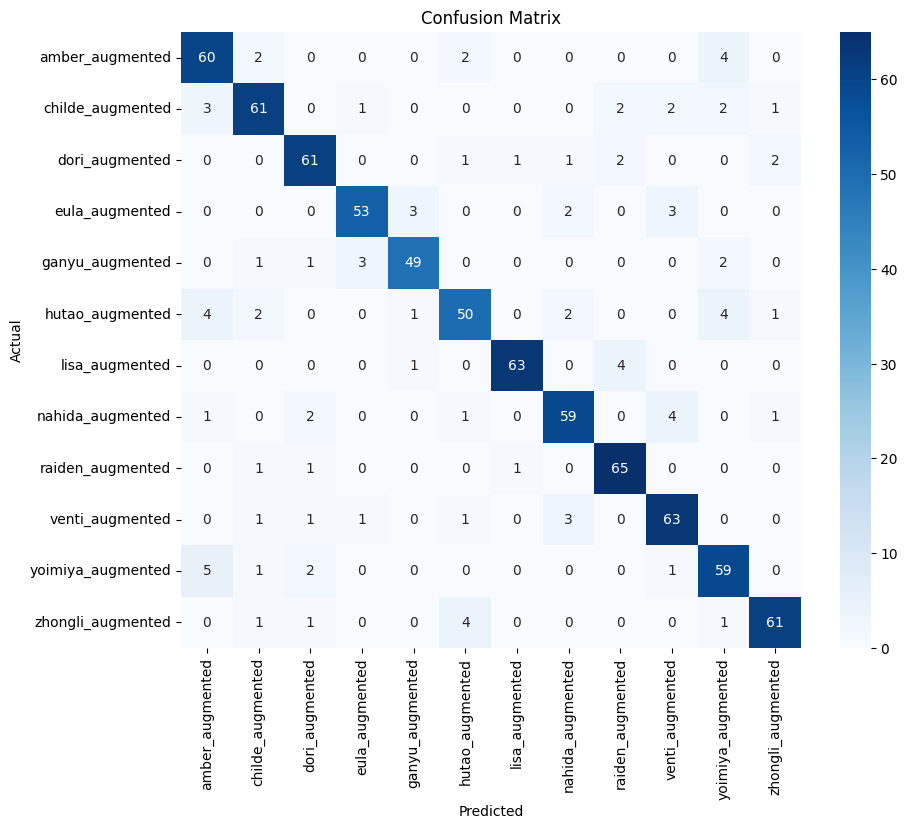

In [41]:
evaluate_model(model, test_loader, device)